In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch running on " , DEVICE , ".\n")

# Define VAE architecture
class VAE(nn.Module):
    def __init__(self, num_channels, height, width, latent_size):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*height*width, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.mean = nn.Sequential(
            nn.Linear(256, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size,latent_size)
        )
        
        self.logvar = nn.Sequential(
            nn.Linear(256, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size,latent_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_size,16*height*width),
            nn.ReLU(),
            nn.Unflatten(1,(16,height,width)),
            nn.Conv2d(16, 16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, num_channels, kernel_size=3,stride=1,padding=1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decode
        x_recon = self.decoder(z)
        
        # Normalize along the 3rd and 4th dimensions (height and width)
        #min_values, _ = torch.min(x_recon, dim=2, keepdim=True)
        #min_values, _ = torch.min(min_values, dim=3, keepdim=True)

        #max_values, _ = torch.max(x_recon, dim=2, keepdim=True)
        #max_values, _ = torch.max(max_values, dim=3, keepdim=True)

        #x_recon = (x_recon - min_values) / (max_values - min_values)
        
        return x_recon, mu, logvar

# Training function
def train_vae(model, dataloader, num_epochs=10, learning_rate=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in trange(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = batch[0].to(device)  # Ignore labels from ImageFolder
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x,x,reduction="sum")
    
    # Reconstruction loss
    MSE = F.mse_loss(recon_x, x)
    
    MAE = F.l1_loss(recon_x, x)
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MAE + 1e-2 * KLD



Torch running on  cuda .



In [2]:
# Test function
def test_vae(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(batch)

            # Visualize original and reconstructed images
            visualize_images(batch, recon_batch)

# Visualization function
def visualize_images(original, reconstructed, num_images=5):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        
        reconstructed[i] = (reconstructed[i] - np.min(reconstructed[i])) / (np.max(reconstructed[i]) - np.min(reconstructed[i]))
        
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed images
        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.show()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, input_folder, output_folder, transform=None):
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.transform = transform

        self.input_images = os.listdir(input_folder)
        self.output_images = os.listdir(output_folder)

    def __len__(self):
        return min(len(self.input_images), len(self.output_images))

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_folder, self.input_images[idx])
        output_path = os.path.join(self.output_folder, self.output_images[idx])

        input_image = Image.open(input_path)
        output_image = Image.open(output_path) #.convert('RGB')  # Convert to grayscale if necessary

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

def get_image_dataloader(input_folder, output_folder, batch_size=64, validation_split=0.6, random_seed=42):
    # Ensure input and output folders exist
    #assert os.path.exists(input_folder), f"Input folder '{input_folder}' does not exist."
    #assert os.path.exists(output_folder), f"Output folder '{output_folder}' does not exist."

    # Define data transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create datasets
    dataset = CustomDataset(input_folder,output_folder, transform=transform)

    # Check if the number of samples in input and output datasets match
    #assert len(input_dataset) == len(output_dataset), "Input and output datasets must have the same number of samples."

    # Randomly split the datasets into training and validation sets
    total_samples = len(dataset)
    validation_size = int(validation_split * total_samples)
    train_size = total_samples - validation_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])


    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [4]:
if __name__ == "__main__":
    # Set your data path and other parameters
    input_image_path = "C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/toy_dataset"
    output_image_path= "C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/toy_dataset"
    
    batch_size = 10
    num_channels = 3  # Adjust based on your data
    height = 218
    width = 178
    latent_size = 20  # Adjust based on your desired latent space dimension

    # Initialize VAE
    vae_model = VAE(num_channels=num_channels, height = height, width = width, latent_size=latent_size)

    # Get data loader
    train_loader, val_loader = get_image_dataloader(input_image_path,output_image_path,batch_size)


    train=1
    if train:
        # Train VAE
        train_vae(vae_model, train_loader, num_epochs=200)
    
    

    
    # Instantiate the Convolutional VAE model and optimizer
    #conv_vae = ConvVAE(in_channels=1, out_channels=3,latent_size=latent_size)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/200, Loss: 28823828026.9276


Epoch 2/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/200, Loss: 52328.8137


Epoch 3/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/200, Loss: 8937.4935


Epoch 4/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/200, Loss: 477.7499


Epoch 5/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/200, Loss: 18.6664


Epoch 6/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/200, Loss: 18.6725


Epoch 7/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/200, Loss: 18.6686


Epoch 8/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/200, Loss: 18.6206


Epoch 9/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/200, Loss: 18.5623


Epoch 10/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/200, Loss: 18.5014


Epoch 11/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/200, Loss: 18.4062


Epoch 12/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/200, Loss: 18.3284


Epoch 13/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/200, Loss: 18.2314


Epoch 14/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/200, Loss: 18.1317


Epoch 15/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/200, Loss: 18.0337


Epoch 16/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/200, Loss: 17.9395


Epoch 17/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/200, Loss: 17.8176


Epoch 18/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/200, Loss: 17.7132


Epoch 19/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/200, Loss: 17.6038


Epoch 20/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/200, Loss: 17.4895


Epoch 21/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/200, Loss: 17.3807


Epoch 22/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/200, Loss: 17.2760


Epoch 23/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/200, Loss: 17.1659


Epoch 24/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/200, Loss: 17.0463


Epoch 25/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/200, Loss: 16.9374


Epoch 26/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/200, Loss: 16.8259


Epoch 27/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/200, Loss: 16.7193


Epoch 28/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/200, Loss: 16.6089


Epoch 29/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/200, Loss: 16.4887


Epoch 30/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/200, Loss: 16.3790


Epoch 31/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/200, Loss: 16.2700


Epoch 32/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/200, Loss: 16.1537


Epoch 33/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/200, Loss: 16.0378


Epoch 34/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/200, Loss: 15.9293


Epoch 35/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/200, Loss: 15.8176


Epoch 36/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/200, Loss: 15.7118


Epoch 37/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/200, Loss: 15.5914


Epoch 38/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/200, Loss: 15.4798


Epoch 39/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/200, Loss: 15.3690


Epoch 40/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/200, Loss: 15.2568


Epoch 41/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/200, Loss: 15.1430


Epoch 42/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/200, Loss: 15.0245


Epoch 43/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/200, Loss: 14.9145


Epoch 44/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/200, Loss: 14.8065


Epoch 45/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/200, Loss: 14.6983


Epoch 46/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/200, Loss: 14.5818


Epoch 47/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/200, Loss: 14.4690


Epoch 48/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/200, Loss: 14.3584


Epoch 49/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/200, Loss: 14.2498


Epoch 50/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/200, Loss: 14.1428


Epoch 51/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/200, Loss: 14.0310


Epoch 52/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/200, Loss: 13.9212


Epoch 53/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/200, Loss: 13.8206


Epoch 54/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/200, Loss: 13.7021


Epoch 55/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/200, Loss: 13.5952


Epoch 56/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/200, Loss: 13.4937


Epoch 57/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/200, Loss: 13.3779


Epoch 58/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/200, Loss: 13.2773


Epoch 59/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/200, Loss: 13.1679


Epoch 60/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/200, Loss: 13.0649


Epoch 61/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/200, Loss: 12.9605


Epoch 62/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/200, Loss: 12.8529


Epoch 63/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/200, Loss: 12.7516


Epoch 64/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/200, Loss: 12.6494


Epoch 65/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/200, Loss: 12.5398


Epoch 66/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/200, Loss: 12.4409


Epoch 67/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/200, Loss: 12.3440


Epoch 68/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/200, Loss: 12.2410


Epoch 69/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/200, Loss: 12.1421


Epoch 70/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/200, Loss: 12.0452


Epoch 71/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/200, Loss: 11.9450


Epoch 72/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/200, Loss: 11.8410


Epoch 73/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/200, Loss: 11.7502


Epoch 74/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/200, Loss: 11.6510


Epoch 75/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/200, Loss: 11.5610


Epoch 76/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/200, Loss: 11.4570


Epoch 77/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/200, Loss: 11.3649


Epoch 78/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/200, Loss: 11.2623


Epoch 79/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/200, Loss: 11.1755


Epoch 80/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/200, Loss: 11.0775


Epoch 81/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/200, Loss: 10.9938


Epoch 82/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/200, Loss: 10.8968


Epoch 83/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/200, Loss: 10.7987


Epoch 84/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/200, Loss: 10.7133


Epoch 85/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/200, Loss: 10.6299


Epoch 86/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/200, Loss: 10.5331


Epoch 87/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/200, Loss: 10.4475


Epoch 88/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/200, Loss: 10.3534


Epoch 89/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/200, Loss: 10.2609


Epoch 90/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/200, Loss: 10.1861


Epoch 91/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/200, Loss: 10.0913


Epoch 92/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/200, Loss: 10.0021


Epoch 93/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/200, Loss: 9.9254


Epoch 94/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/200, Loss: 9.8364


Epoch 95/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/200, Loss: 9.7541


Epoch 96/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/200, Loss: 9.6688


Epoch 97/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/200, Loss: 9.5857


Epoch 98/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/200, Loss: 9.5042


Epoch 99/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/200, Loss: 9.4246


Epoch 100/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/200, Loss: 9.3491


Epoch 101/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 101/200, Loss: 9.2685


Epoch 102/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 102/200, Loss: 9.1819


Epoch 103/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 103/200, Loss: 9.1027


Epoch 104/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 104/200, Loss: 9.0233


Epoch 105/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 105/200, Loss: 8.9487


Epoch 106/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 106/200, Loss: 8.8695


Epoch 107/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 107/200, Loss: 8.7971


Epoch 108/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 108/200, Loss: 8.7099


Epoch 109/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 109/200, Loss: 8.6347


Epoch 110/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 110/200, Loss: 8.5666


Epoch 111/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 111/200, Loss: 8.4887


Epoch 112/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 112/200, Loss: 8.4165


Epoch 113/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 113/200, Loss: 8.3433


Epoch 114/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 114/200, Loss: 8.2681


Epoch 115/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 115/200, Loss: 8.1978


Epoch 116/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 116/200, Loss: 8.1305


Epoch 117/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 117/200, Loss: 8.0564


Epoch 118/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 118/200, Loss: 7.9938


Epoch 119/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 119/200, Loss: 7.9139


Epoch 120/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 120/200, Loss: 7.8420


Epoch 121/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 121/200, Loss: 7.7777


Epoch 122/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 122/200, Loss: 7.7102


Epoch 123/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 123/200, Loss: 7.6426


Epoch 124/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 124/200, Loss: 7.5757


Epoch 125/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 125/200, Loss: 7.5151


Epoch 126/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 126/200, Loss: 7.4401


Epoch 127/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 127/200, Loss: 7.3803


Epoch 128/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 128/200, Loss: 7.3149


Epoch 129/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 129/200, Loss: 7.2498


Epoch 130/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 130/200, Loss: 7.1877


Epoch 131/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 131/200, Loss: 7.1254


Epoch 132/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 132/200, Loss: 7.0690


Epoch 133/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 133/200, Loss: 7.0025


Epoch 134/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 134/200, Loss: 6.9409


Epoch 135/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 135/200, Loss: 6.8898


Epoch 136/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 136/200, Loss: 6.8229


Epoch 137/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 137/200, Loss: 6.7607


Epoch 138/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 138/200, Loss: 6.7017


Epoch 139/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 139/200, Loss: 6.6424


Epoch 140/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 140/200, Loss: 6.5787


Epoch 141/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141/200, Loss: 6.5301


Epoch 142/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 142/200, Loss: 6.4688


Epoch 143/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 143/200, Loss: 6.4162


Epoch 144/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 144/200, Loss: 6.3615


Epoch 145/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 145/200, Loss: 6.3094


Epoch 146/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 146/200, Loss: 6.2552


Epoch 147/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 147/200, Loss: 6.1972


Epoch 148/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 148/200, Loss: 6.1400


Epoch 149/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 149/200, Loss: 6.0862


Epoch 150/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 150/200, Loss: 6.0351


Epoch 151/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 151/200, Loss: 5.9907


Epoch 152/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 152/200, Loss: 5.9287


Epoch 153/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 153/200, Loss: 5.8810


Epoch 154/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 154/200, Loss: 5.8289


Epoch 155/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 155/200, Loss: 5.7761


Epoch 156/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 156/200, Loss: 5.7234


Epoch 157/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 157/200, Loss: 5.6742


Epoch 158/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 158/200, Loss: 5.6403


Epoch 159/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 159/200, Loss: 5.5861


Epoch 160/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 160/200, Loss: 5.5325


Epoch 161/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161/200, Loss: 5.4857


Epoch 162/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 162/200, Loss: 5.4389


Epoch 163/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 163/200, Loss: 5.3902


Epoch 164/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 164/200, Loss: 5.3461


Epoch 165/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 165/200, Loss: 5.3011


Epoch 166/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 166/200, Loss: 5.2630


Epoch 167/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 167/200, Loss: 5.2158


Epoch 168/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 168/200, Loss: 5.1738


Epoch 169/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 169/200, Loss: 5.1303


Epoch 170/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 170/200, Loss: 5.0853


Epoch 171/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 171/200, Loss: 5.0352


Epoch 172/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 172/200, Loss: 4.9969


Epoch 173/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 173/200, Loss: 4.9534


Epoch 174/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 174/200, Loss: 4.9147


Epoch 175/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 175/200, Loss: 4.8798


Epoch 176/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 176/200, Loss: 4.8371


Epoch 177/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 177/200, Loss: 4.7895


Epoch 178/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 178/200, Loss: 4.7549


Epoch 179/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 179/200, Loss: 4.7126


Epoch 180/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 180/200, Loss: 4.6721


Epoch 181/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 181/200, Loss: 4.6408


Epoch 182/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 182/200, Loss: 4.6000


Epoch 183/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 183/200, Loss: 4.5632


Epoch 184/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 184/200, Loss: 4.5204


Epoch 185/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 185/200, Loss: 4.4898


Epoch 186/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 186/200, Loss: 4.4488


Epoch 187/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 187/200, Loss: 4.4116


Epoch 188/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 188/200, Loss: 4.3769


Epoch 189/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 189/200, Loss: 4.3462


Epoch 190/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 190/200, Loss: 4.3067


Epoch 191/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 191/200, Loss: 4.2748


Epoch 192/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 192/200, Loss: 4.2406


Epoch 193/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 193/200, Loss: 4.2117


Epoch 194/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 194/200, Loss: 4.1705


Epoch 195/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 195/200, Loss: 4.1387


Epoch 196/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 196/200, Loss: 4.1031


Epoch 197/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 197/200, Loss: 4.0768


Epoch 198/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 198/200, Loss: 4.0445


Epoch 199/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 199/200, Loss: 4.0097


Epoch 200/200:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 200/200, Loss: 3.9822


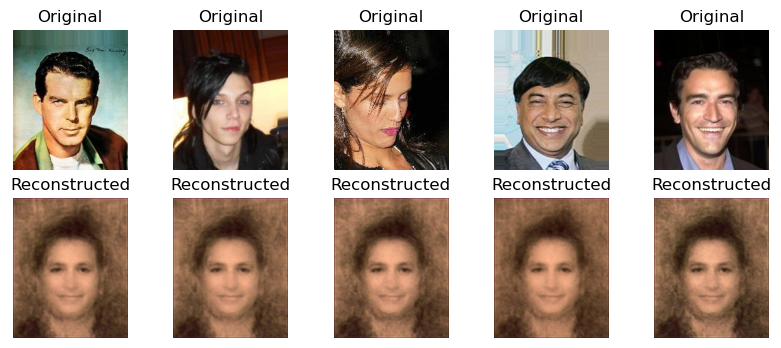

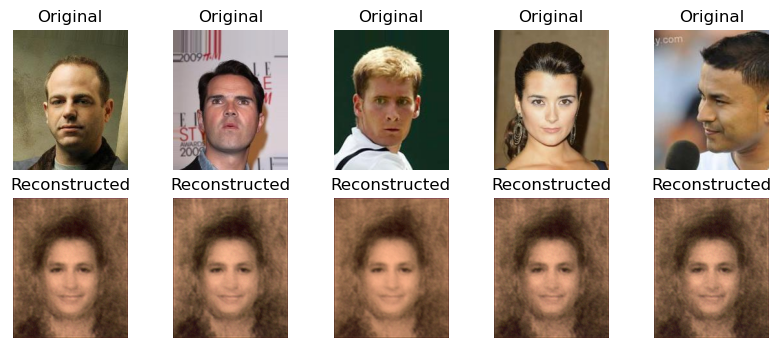

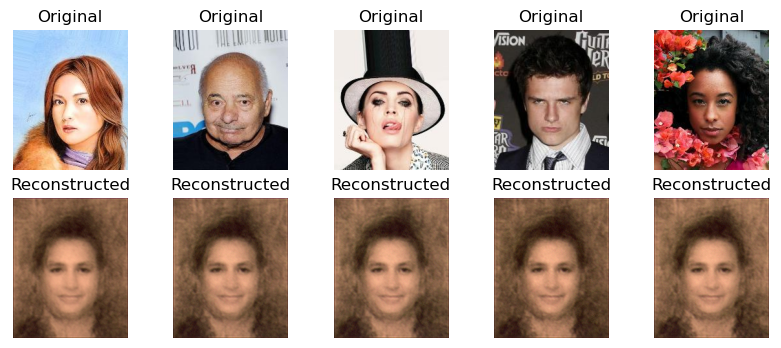

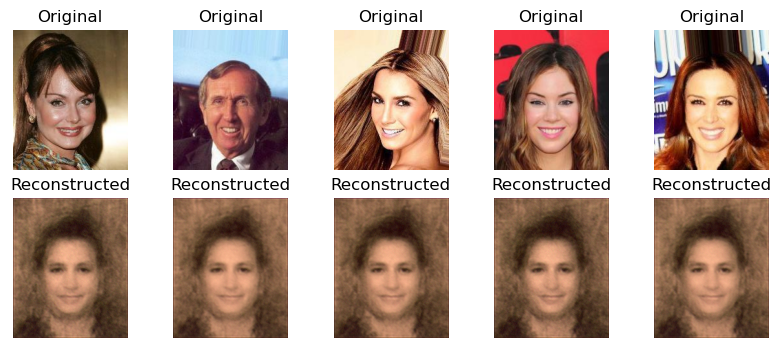

IndexError: index 4 is out of bounds for axis 0 with size 4

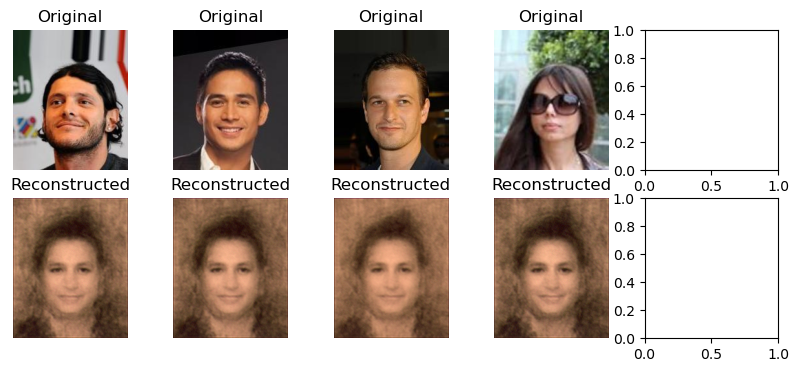

In [5]:
test_vae(vae_model,train_loader)

In [6]:
# save the model weights
save_params= 1
if save_params:
    torch.save(vae_model.state_dict(), "c2c_200epochs_MAE.pth")
    torch.save(vae_model, "model_c2c_200epochs_MAE.pth")

In [7]:
vae_model.load_state_dict(torch.load("c2c_200epochs_MAE.pth"))
vae_model.eval()  # Set model to evaluation mode

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=620864, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
  )
  (mean): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (logvar): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=20, out_features=620864, bias=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(16, 218, 178))
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 